In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import os
import sys

if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))
    
from utils.classification import load_model, load_features, load_data, weighted_smoothing
from utils.meta import *
from tqdm import notebook
import pickle
import os
import pandas as pd

### load model, preprocessed pose (filter out low likelihood), and binned features (smoothed distances, speed, angle etc)

In [3]:
model_path = '../model/model.pkl'
model = load_model(model_path)
data_path = '../processed_dataset/raw_data_SNI_mMORp-DREADD_sex.pkl'
poses = load_data(data_path)
features_path = '../processed_dataset/binned_features_SNI_mMORp-DREADD_sex.pkl'
features = load_features(features_path)

### predict behaviors based on features

In [4]:
repeat_n = 6
if 'behaviors_sni_sex.pkl' not in os.listdir('../processed_dataset/'): 
    behaviors = {key: [] for key in groups_sni_sex}
    for group in notebook.tqdm(groups_sni_sex):
        behaviors[group] = {key: [] for key in conditions_sni_sex}
        for condition in notebook.tqdm(conditions_sni_sex):
            behaviors[group][condition] = {key: [] for key in [f'file{i}' 
                                               for i in range(len(poses[group][condition]))]}

            for i in range(len(poses[group][condition])):
                total_n_frames = poses[group][condition][f'file{i}'].shape[0]
                # predict downsampled features
                predict_ds = model.predict(features[group][condition][f'file{i}'][0])
                # upsample by duplicating
                predictions = np.pad(predict_ds.repeat(repeat_n), (repeat_n, 0), 'edge')[:total_n_frames]
                # smooth with minimum 12 frames (200ms)
                behaviors[group][condition][f'file{i}'] = weighted_smoothing(predictions, size=12)
else:
    features = load_features('../processed_dataset/behaviors_sni_sex.pkl')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
if 'behaviors_sni_sex.pkl' not in os.listdir('../processed_dataset/'):
    with open('../processed_dataset/behaviors_sni_sex.pkl', 'wb') as f:
        pickle.dump(behaviors, f)
else:
    print('Predicted behaviors exists!')

In [21]:
behaviors['Male']['Control']['file1'][:3600] # 3600frames = 1 minute (60*60)

array([1, 1, 1, ..., 2, 2, 2])

### quick view of example behavior distribution

In [7]:
selected_group = groups_sni_sex[0]
selected_condition = 'control_mMORP-eYFP_MALE'

predict_dict = {'condition': np.repeat(selected_condition, 
                                       len(np.hstack([behaviors[selected_group][selected_condition][f'file{i}'] 
                                                      for i in range(len(behaviors[selected_group][selected_condition]))]))),
                'behavior': np.hstack([behaviors[selected_group][selected_condition][f'file{i}'] 
                                       for i in range(len(behaviors[selected_group][selected_condition]))])}
df_raw = pd.DataFrame(data=predict_dict)
labels = df_raw['behavior'].value_counts(sort=False).index
values = df_raw['behavior'].value_counts(sort=False).values
# summary dataframe
df = pd.DataFrame()
behavior_labels = []
for l in labels:
    behavior_labels.append(behavior_names[int(l)])
df["values"] = values
df['labels'] = behavior_labels
df["colors"] = df["labels"].apply(lambda x:
                                  behavior_colors[behavior_names.index(x)])  # to connect Column value to Color in Dict
df

,values,labels,colors
0,253757,rearing,goldenrod
1,446375,walking,darkcyan
2,87102,grooming,royalblue
3,335809,still,crimson
4,666,licking hindpaw L,rebeccapurple
5,1284,licking hindpaw_R,mediumorchid


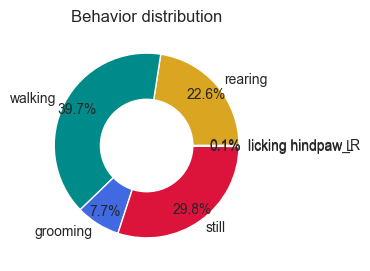

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
# Pie Chart
ax.pie(df['values'], 
       colors=df['colors'], 
       labels=df['labels'],
       autopct='%1.1f%%', pctdistance=0.85)
# draw circle
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
ax.set_title('Behavior distribution')
# Displaying Chart
plt.show()

### file save, change the extension to change the file format

In [18]:
fig.savefig(f'../figures/Study5_example_distribution_'
            f'{selected_drug}_{selected_group}_{selected_condition}.svg', 
            dpi=600, bbox_inches='tight')